Downloading...
From: https://drive.google.com/uc?id=1IOgB_HQs0BrXsD4DssDnHAlsmtmWCEN7
To: /content/scu-ai-competition-202401.zip
100% 98.8k/98.8k [00:00<00:00, 77.3MB/s]
Train shape: (4223, 18)
Test shape: (3456, 17)


<ipython-input-3-093e36285069>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_ft[name] = train_ft[list(comb)].sum(axis=1)
<ipython-input-3-093e36285069>:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_ft[name] = test_ft[list(comb)].sum(axis=1)
<ipython-input-3-093e36285069>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented

  0%|          | 0/91 [00:00<?, ?it/s]

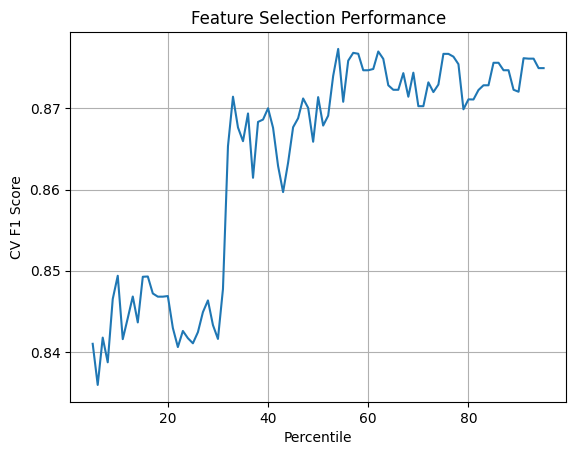

Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.100069
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.0787768
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.0741183
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.0797483
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[57]	valid_0's binary_logloss: 0.083321
Validation F1 Scores per Fold: [0.8526315789473684, 0.8808290155440415, 0.8944723618090452, 0.8704663212435233, 0.8775510204081632]
Average Validation F1 Score: 0.8751900595904283


In [ ]:

# ===========================
# 🔽 1. Download and unzip data
# ===========================
!gdown 1IOgB_HQs0BrXsD4DssDnHAlsmtmWCEN7  # Download data file
!unzip -oqq scu-ai-competition-202401.zip  # Unzip the dataset

# ===========================
# 🔽 2. Environment setup
# ===========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.preprocessing import (
    OneHotEncoder,
    MinMaxScaler,
    StandardScaler,
    RobustScaler,
    PowerTransformer,
)
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier, early_stopping
from tqdm.auto import tqdm


SEED = 42
DATA_PATH = "./"

# ===========================
# 🔽 3. Load datasets
# ===========================
train = pd.read_csv(f"{DATA_PATH}train.csv")
test = pd.read_csv(f"{DATA_PATH}test.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)

# ===========================
# 🔽 4. Handle missing values
# ===========================
# Fill numerical columns with mean
fill_tsh = train["TSH"].mean()
fill_free_t3 = train["FreeT3"].mean()
fill_free_t4 = train["FreeT4"].mean()

# Common preprocessing for both train and test
for df in [train, test]:
    df["나이"] = df["나이"].fillna(0)
    df["성별"] = df["성별"].fillna("UNK")
    df["TSH"] = df["TSH"].fillna(fill_tsh)
    df["FreeT3"] = df["FreeT3"].fillna(fill_free_t3)
    df["FreeT4"] = df["FreeT4"].fillna(fill_free_t4)

# ===========================
# 🔽 5. Convert binary categorical features
# ===========================
binary_cols = [col for col in train.columns if col.endswith("여부") or col.endswith("이력")]
for df in [train, test]:
    df[binary_cols] = (df[binary_cols] == "예").astype(int)

# ===========================
# 🔽 6. Feature engineering
# ===========================
# Remove ID and target column
train_ft = train.iloc[:, 1:-1].copy()
test_ft = test.iloc[:, 1:].copy()

# Add a feature representing total 'yes' counts
train_ft["yes_sum"] = train_ft[binary_cols].sum(axis=1)
test_ft["yes_sum"] = test_ft[binary_cols].sum(axis=1)

# Create interaction features using 2- and 3-way combinations
for n in [2, 3]:
    for comb in combinations(binary_cols, n):
        name = "_".join(comb)
        train_ft[name] = train_ft[list(comb)].sum(axis=1)
        test_ft[name] = test_ft[list(comb)].sum(axis=1)

# Add a ratio feature between FreeT4 and FreeT3
train_ft["FreeT4_FreeT3"] = train_ft["FreeT4"] / train_ft["FreeT3"]
test_ft["FreeT4_FreeT3"] = test_ft["FreeT4"] / test_ft["FreeT3"]

# ===========================
# 🔽 7. One-hot encoding
# ===========================
cat_cols = train_ft.select_dtypes("object").columns.tolist()
ohe = OneHotEncoder(handle_unknown="ignore")

train_ohe = pd.DataFrame(
    ohe.fit_transform(train_ft[cat_cols]).toarray(),
    columns=ohe.get_feature_names_out(cat_cols)
)
test_ohe = pd.DataFrame(
    ohe.transform(test_ft[cat_cols]).toarray(),
    columns=ohe.get_feature_names_out(cat_cols)
)

train_ft = pd.concat([train_ft.drop(columns=cat_cols), train_ohe], axis=1)
test_ft = pd.concat([test_ft.drop(columns=cat_cols), test_ohe], axis=1)

# ===========================
# 🔽 8. Feature scaling
# ===========================
scaler = MinMaxScaler()
train_ft[:] = scaler.fit_transform(train_ft)
test_ft[:] = scaler.transform(test_ft)



# ===========================
# 🔽 9. Set target variable
# ===========================
target = train["target"]

# ===========================
# 🔽 10. Feature selection using SelectPercentile
# ===========================
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
cv_scores = []

# Evaluate performance across percentiles (5% to 95%)
for p in tqdm(range(5, 96)):
    selector = SelectPercentile(percentile=p)
    selector.fit(train_ft, target)
    X_selected = selector.transform(train_ft)

    model = LGBMClassifier(random_state=SEED)
    scores = cross_val_score(model, X_selected, target, cv=cv, scoring="f1", n_jobs=-1)
    cv_scores.append([p, scores.mean()])

# Identify the best percentile
cv_scores = np.array(cv_scores)
best_idx = np.argmax(cv_scores[:, 1])
best_percentile = cv_scores[best_idx, 0]

# Plot performance
plt.plot(cv_scores[:, 0], cv_scores[:, 1])
plt.xlabel("Percentile")
plt.ylabel("CV F1 Score")
plt.grid(True)
plt.title("Feature Selection Performance")
plt.show()

# Select features using the best percentile
selector = SelectPercentile(percentile=best_percentile)
selector.fit(train_ft, target)
best_features = selector.get_feature_names_out()

train_ft = train_ft[best_features]
test_ft = test_ft[best_features]

# ===========================
# 🔽 11. Train model using K-Fold Cross Validation
# ===========================
from lightgbm import LGBMClassifier, early_stopping
from sklearn.metrics import f1_score

model_list = []
score_list = []

for train_idx, valid_idx in cv.split(train_ft, target):
    X_train, y_train = train_ft.iloc[train_idx], target.iloc[train_idx]
    X_valid, y_valid = train_ft.iloc[valid_idx], target.iloc[valid_idx]

    model = LGBMClassifier(
        random_state=SEED,
        n_estimators=1000,
        verbosity=-1
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        callbacks=[early_stopping(300)]
    )

    pred = model.predict(X_valid)
    score = f1_score(y_valid, pred)

    score_list.append(score)
    model_list.append(model)

print("Validation F1 Scores per Fold:", score_list)
print("Average Validation F1 Score:", np.mean(score_list))

# ===========================
# 🔽 12. Predict on test set with soft voting
# ===========================
pred_list = [model.predict_proba(test_ft)[:, 1] for model in model_list]
pred = np.mean(pred_list, axis=0)
pred_binary = (pred > 0.5).astype(int)

# ===========================
# 🔽 13. Create submission file
# ===========================
submit = pd.read_csv(f"{DATA_PATH}sample_submission.csv")
submit["target"] = pred_binary
submit.to_csv("AI_Competiton_Submit.csv", index=False)
